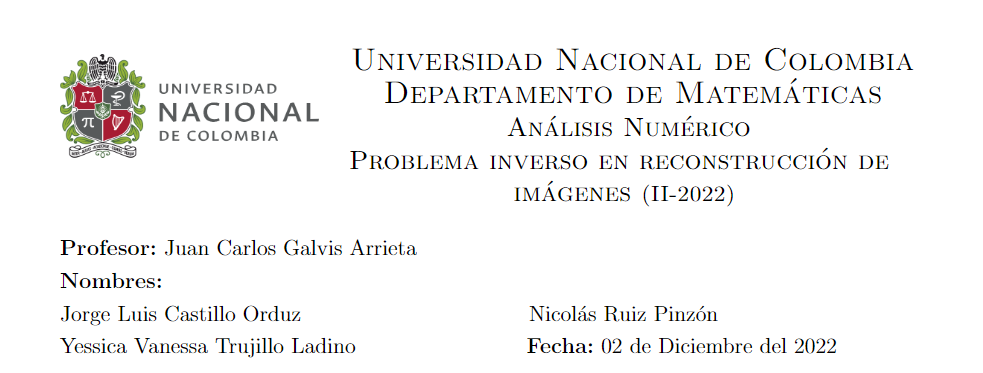

<br><br>
<h2 style="color:darkblue">IMPLEMENTACIÓN DE LOS MÉTODOS</h2>

<h3 style="color:teal"> OPTIMIZACIÓN CONVEXA</h3>

<h4>Paquetes a instalar</h4>

In [1]:
# !pip install cvxpy
# !pip install numpy
# !pip install opencv-python
# !pip install tensorflow
# !pip install tabulate

<h4>Funciones para calcular los parámetros que usaremos en nuestro modelo</h4>

In [2]:
def plot_results(HazeImg, HazeCorrectedImg):
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,15))
    axes.ravel()
    rgb_img_original = cv2.cvtColor(HazeImg, cv2.COLOR_BGR2RGB)
    rgb_img_dehazed = cv2.cvtColor(HazeCorrectedImg, cv2.COLOR_BGR2RGB)
    axes[0].imshow(rgb_img_original)
    axes[0].title.set_text("Imagen original")
    axes[1].imshow(rgb_img_dehazed)
    axes[1].title.set_text("Imagen reconstruida")
    fig.tight_layout()
    plt.show()

    fig1, axes1 = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
    axes1[0].title.set_text("Histograma de intensidad de luz")
    axes1[0].hist(HazeImg.ravel(),256,[0,256])
    axes1[1].title.set_text("Histograma de intensidad de luz")
    axes1[1].hist(HazeCorrectedImg.ravel(),256,[0,256])
    fig1.tight_layout()

    fig2, axes2 = plt.subplots(nrows=1, ncols=2,figsize=(15,5))

    for channel_id, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            HazeImg[:, :, channel_id], bins=256, range=(0, 256)
        )
        axes2[0].plot(bin_edges[0:-1], histogram, color=color)
    fig2.tight_layout()
    axes2[0].title.set_text("Histograma de colores por canal");    
    axes2[1].title.set_text("Histograma de colores por canal");  

    # fig2.tight_layout()
    for channel_id, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            HazeCorrectedImg[:, :, channel_id], bins=256, range=(0, 256)
        )
        axes2[1].plot(bin_edges[0:-1], histogram, color=color)

    fig2.tight_layout()


In [3]:
import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt

# Calculamos A para encontrar la luz del aire

def Airlight(HazeImg, windowSize):
    A = []
    for ch in range(len(HazeImg.shape)):
      kernel = np.ones((windowSize, windowSize), np.uint8)
      minImg = cv2.erode(HazeImg[:, :, ch], kernel)
#       plt.imshow(cv2.erode(HazeImg[:, :, ch], kernel))
#       plt.show()
      A.append(int(minImg.max()))
    return(A)

In [4]:
# Calculamos la función de transmisión para cada pixel. La matriz que retornamos 
# es del mismo tamaño de la imagen de entrada y cada elemento tendra un valor entre 0 y 1

def TransmissionOC(HazeImg, A, C0, C1):    
    t_b = np.maximum((A[0] - HazeImg[:, :, 0].astype(float)) / (A[0] - C0),
                      (HazeImg[:, :, 0].astype(float) - A[0]) / (C1 - A[0]))
    t_g = np.maximum((A[1] - HazeImg[:, :, 1].astype(float)) / (A[1] - C0),
                      (HazeImg[:, :, 1].astype(float) - A[1]) / (C1 - A[1]))
    t_r = np.maximum((A[2] - HazeImg[:, :, 2].astype(float)) / (A[2] - C0),
                      (HazeImg[:, :, 2].astype(float) - A[2]) / (C1 - A[2]))
    MaxVal = np.maximum(t_b, t_g, t_r)
    transmission = np.minimum(MaxVal, 1)
    return(transmission)

<h4>Construcción del modelo usando CVXPY</h4>

In [5]:
%%capture
import cvxpy as cp
from cvxpy.atoms.norm1 import norm1
from cvxpy.atoms.pnorm import pnorm
nombre_im="test1."
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

def removeHaze(HazeImg, delta, Regularize = False):
    windowSize_erode = 25
    A = Airlight(HazeImg, windowSize_erode)
    C0=20
    C1=300
    Transmission = TransmissionOC(HazeImg,A,C0,C1)
    epsilon = 0.0001
    Transmission = pow(np.maximum(abs(Transmission), epsilon), delta)
    HazeCorrectedImage = copy.deepcopy(HazeImg)
    for ch in range(len(HazeImg.shape)):
        # Definimos los parámetros para construir el modelo en CVXPY
        I_c = cp.Parameter(HazeImg[:, :, ch].shape)
        I_c.value = HazeImg[:, :, ch]        
        t_c = cp.Parameter(Transmission.shape)
        t_c.value = Transmission
        a_c = cp.Parameter()
        a_c.value = A[ch]

        # Definimos la variable a optimizar, que en este caso es la imagen sin niebla que queremos recuperar
        J_c = cp.Variable(HazeCorrectedImage[:, :, ch].shape)
        J_c.value = HazeCorrectedImage[:, :, ch]

        # Si el canal que se optimiza es el azul se escoge un lamba_2 ligeramente más grande para obtener mejores resultados
        if ch==2:            
            lambda_1 = -0.01
            lambda_2 = 0.0015
        else:
            lambda_1 = -0.01
            lambda_2 = 0.001

        # Definimos la expresión que vamos a minimizar        
        if Regularize:
          expression = I_c-(cp.multiply(J_c,t_c) + a_c*(1-t_c))+(lambda_1*(cp.norm(t_c,p=2).value))+lambda_2*cp.tv(t_c).value
        else:
          expression = I_c-(cp.multiply(J_c,t_c) + a_c*(1-t_c))        
        objective = cp.Minimize(cp.sum_squares(expression))

        # Definimos las restricciones, que en este caso es que cada pixel tenga un valor entre 0 y 255
        constraints = [0 <= J_c, J_c <= 255]
        prob = cp.Problem(objective, constraints);        
        prob.solve();
        temp = J_c.value;
        temp = np.maximum(np.minimum(temp, 255), 0)
        HazeCorrectedImage[:, :, ch] = temp    
    return(HazeCorrectedImage)  

<h4>Evaluación</h4>

Ejecutamos el siguiente código para ver un ejemplo de como funciona el problema de reconstrucción de imágenes. Se presenta una imagen de la ciudad de Bogotá en un día nublado y lluvioso.

In [6]:
%%capture
HazeImg = cv2.imread(nombre_im+"jpg")
colors = ("red", "green", "blue")

OCImg = removeHaze(HazeImg, 0.5, False);

# cv2.imwrite("DCPdehazed-"+nombre_im+"png",HazeCorrectedImg)


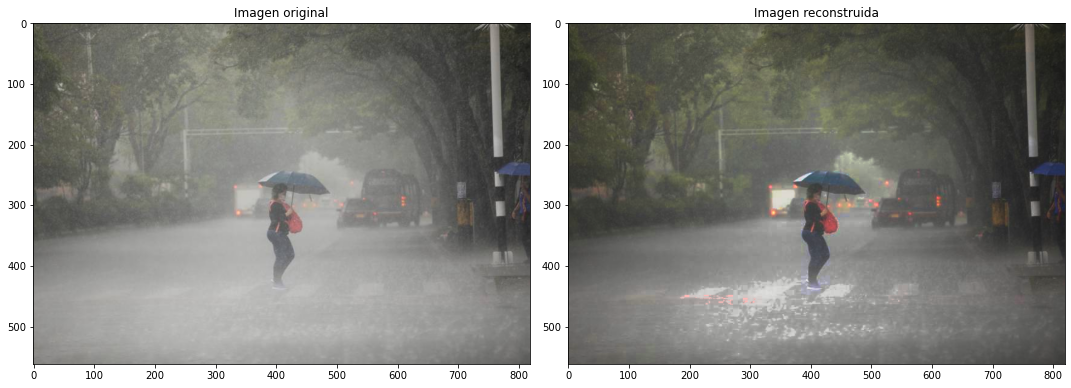

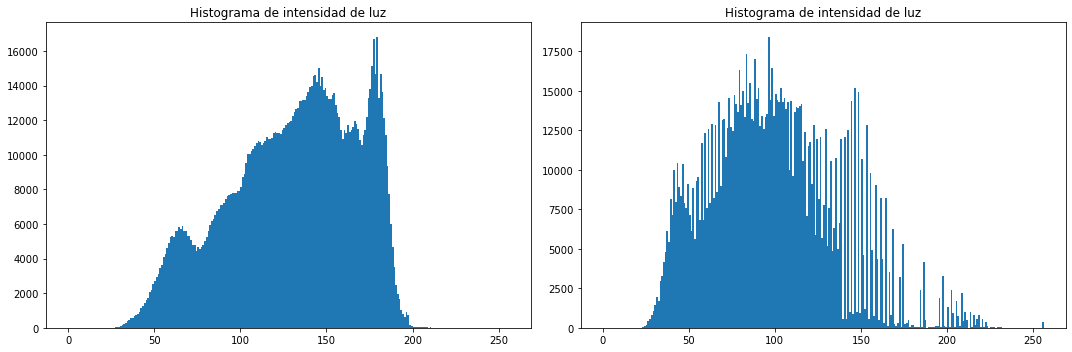

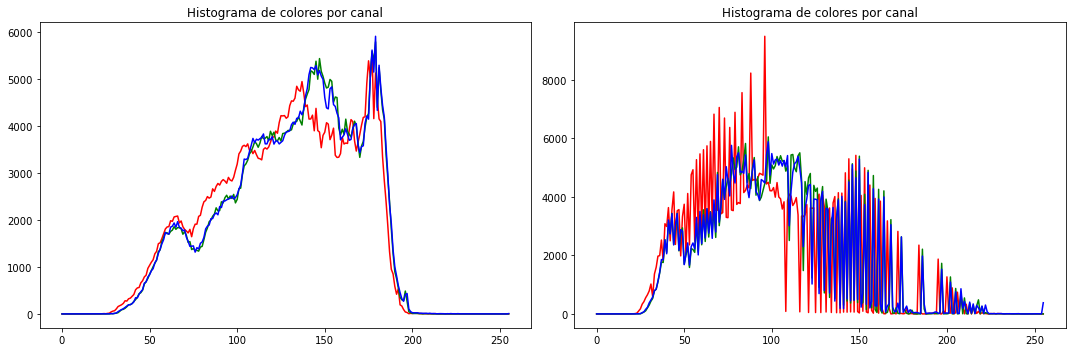

In [7]:
plot_results(HazeImg,OCImg)

<br><br>
<h3 style="color:teal"> MÉTODO ROY-CHAUDHURI</h3>

In [8]:
import scipy.io as io
import urllib.request
import matplotlib.pyplot as plt

In [9]:
def TransmissionRC(HazeImg, A):
    one_matrix = np.ones((HazeImg.shape[0],HazeImg.shape[1]))
    t_b = one_matrix-HazeImg[:, :, 0].astype(float)*(0.95/A[0])
    t_g = one_matrix-HazeImg[:, :, 1].astype(float)*(0.95/A[1])
    t_r = one_matrix-HazeImg[:, :, 2].astype(float)*(0.95/A[2])
    MaxVal = np.maximum(t_b, t_g, t_r)
    transmission = np.minimum(MaxVal, 1)
    return(transmission)

In [10]:
def contrastControllerRC(Image):
    grayscale = cv2.cvtColor(Image, cv2.COLOR_BGR2GRAY)
    num=np.max(grayscale)-np.min(grayscale)
    den=int(np.max(grayscale))+int(np.min(grayscale))
    michelson=num/den
    for ch in range(len(Image.shape)):
        Image[:,:,ch]=Image[:,:,ch]*michelson
    return Image

In [11]:
def removeHazeRC(HazeImg, delta, Regularize = False):
    windowSize_erode=25
    A = Airlight(HazeImg, windowSize_erode)
    Transmission=TransmissionRC(HazeImg, A)
    epsilon = 0.0001
    A_contrast = [(255-x)/255 for x in A]
    A_contrast = [1-np.max(A_contrast)+x for x in A_contrast]
    Transmission = pow(np.maximum(abs(Transmission), epsilon), delta)
    HazeCorrectedImage = copy.deepcopy(HazeImg)
    for ch in range(len(HazeImg.shape)):
        A_matrix = np.ones((HazeImg.shape[0],HazeImg.shape[1]))    
        A_matrix = A_matrix*A[ch]
        temp=np.divide((HazeImg[:, :, ch]-A_matrix),np.maximum(Transmission, epsilon))+A_matrix
        temp = np.maximum(np.minimum(temp, 255), 0)
        HazeCorrectedImage[:, :, ch] = temp    
    return(HazeCorrectedImage) 

<h4>Evaluación</h4>

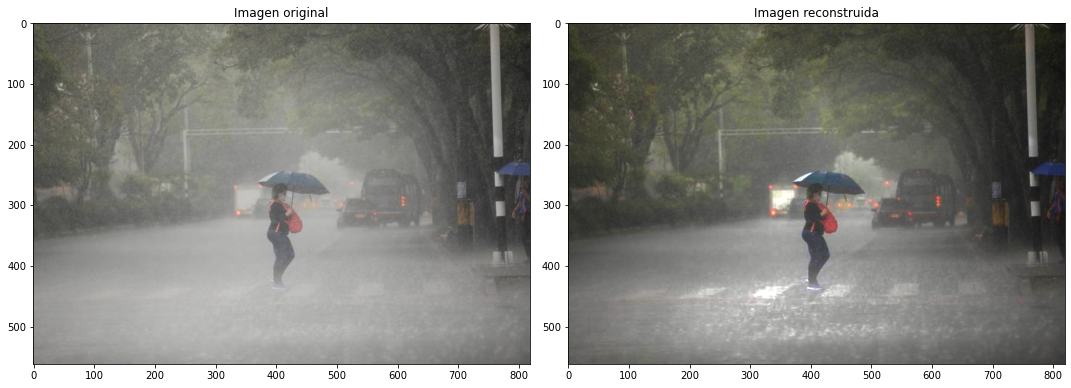

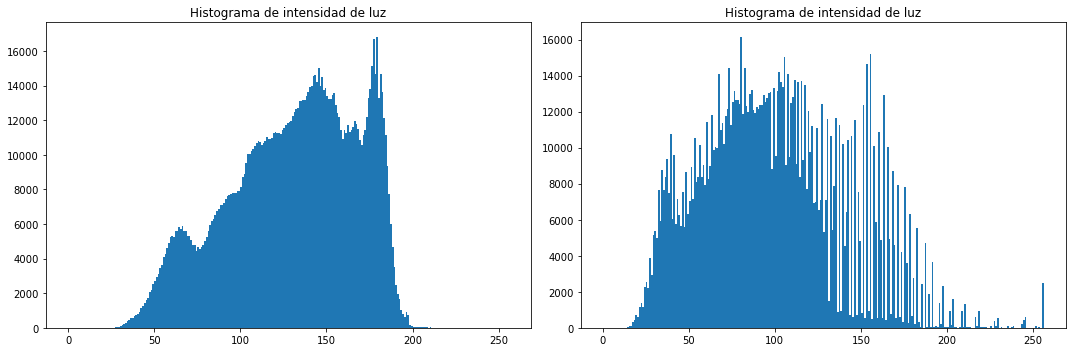

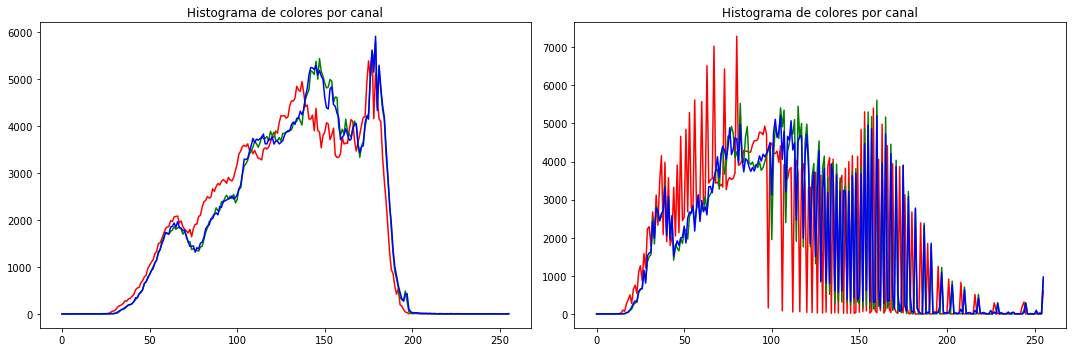

In [12]:
RCImg = removeHazeRC(HazeImg, 0.5, True)

plot_results(HazeImg,RCImg)

# cv2.imwrite("RCdehazed-"+nombre_im+"jpg",RCDehaze)

 <br><br>
 <h3 style="color:teal"> REDES NEURONALES CONVOLUCIONALES (CNN)</h3> 

<h4>Librerías</h4>

In [13]:
import tensorflow.compat.v1 as tf
from tensorflow.keras.layers import *
import os, shutil
import glob
import random
from PIL import Image
import cv2

<h4>Hiperparámetros</h4>

In [14]:
n_epochs = 10
batch_size = 8
learning_rate = 1e-4
weight_decay = 1e-4

<h4>Funciones auxiliares</h4>

In [15]:
def setup_data_paths(orig_images_path,hazy_images_path): 
    orig_image_paths = glob.glob(orig_images_path + "/*.jpg")
    n = len(orig_image_paths) 
    random.shuffle(orig_image_paths)
    train_keys = orig_image_paths[:int(0.90*n)]
    val_keys = orig_image_paths[int(0.90*n):]
    split_dict = {}
    for key in train_keys:
        split_dict[key] = 'train'
    for key in val_keys:
        split_dict[key] = 'val'
  
    train_data = []
    val_data = []
  
    hazy_image_paths = glob.glob(hazy_images_path + "\*.jpg")
    for path in hazy_image_paths:        
        label = path.split('\\')[-1]
        orig_path = orig_images_path + "\\" + label.split('_')[0] + '_' + label.split('_')[1] + ".jpg"
        if(split_dict[orig_path] == 'train'):
          train_data.append([path,orig_path])
        else: val_data.append([path,orig_path])  
    return train_data, val_data

def load_image(X):
    X = tf.io.read_file(X)
    X = tf.image.decode_jpeg(X,channels=3)
    X = tf.image.resize(X,(480,640))
    X = X / 255.0
    return X

def showImage(x):
    x = np.asarray(x*255,dtype=np.int32)
    plt.figure()
    plt.imshow(x)
    plt.show()

In [16]:
def create_datasets(train_data,val_data,batch_size):  
    train_ds_hazy = tf.data.Dataset.from_tensor_slices([data[0] for data in train_data]).map(lambda x: load_image(x))
    train_ds_orig = tf.data.Dataset.from_tensor_slices([data[1] for data in train_data]).map(lambda x: load_image(x))
    train_ds = tf.data.Dataset.zip((train_ds_hazy,train_ds_orig)).shuffle(100).repeat().batch(batch_size)

    val_ds_hazy = tf.data.Dataset.from_tensor_slices([data[0] for data in val_data]).map(lambda x: load_image(x))
    val_ds_orig = tf.data.Dataset.from_tensor_slices([data[1] for data in val_data]).map(lambda x: load_image(x))
    val_ds = tf.data.Dataset.zip((val_ds_hazy,val_ds_orig)).shuffle(100).repeat().batch(batch_size)

    iterator = tf.compat.v1.data.Iterator.from_structure(tf.compat.v1.data.get_output_types(train_ds),tf.compat.v1.data.get_output_shapes(train_ds));
  
    train_init_op = iterator.make_initializer(train_ds);
    val_init_op = iterator.make_initializer(val_ds);
  
    return train_init_op, val_init_op, iterator


<h4>Diseño de la Red Neuronal Convolucional</h4>

In [17]:
def haze_net(X):  
    conv1 = Conv2D(3,1,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=tf.initializers.random_normal(stddev=0.02),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(X)
    conv2 = Conv2D(3,3,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=tf.initializers.random_normal(stddev=0.02),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(conv1)
    concat1 = tf.concat([conv1,conv2],axis=-1)
  
    conv3 = Conv2D(3,5,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=tf.initializers.random_normal(stddev=0.02),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(concat1)
    concat2 = tf.concat([conv2,conv3],axis=-1)
  
    conv4 = Conv2D(3,7,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=tf.initializers.random_normal(stddev=0.02),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(concat2)
    concat3 = tf.concat([conv1,conv2,conv3,conv4],axis=-1)
  
    conv5 = Conv2D(3,3,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=tf.initializers.random_normal(stddev=0.02),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(concat3)
    K = conv5
  
    output = ReLU(max_value=1.0)(tf.math.multiply(K,X) - K + 1.0)
    #output = output / 255.0
  
    return output

In [18]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
np.random.seed(9999)
tf.compat.v1.reset_default_graph()
train_data, val_data = setup_data_paths(os.getcwd()+"/data/orig_images",
                                        os.getcwd()+"/data/hazy_images")
train_init_op, val_init_op, iterator = create_datasets(train_data,val_data,batch_size);
next_element = iterator.get_next();

X = tf.placeholder(shape=(None,480,640,3),dtype=tf.float32)
Y = tf.placeholder(shape=(None,480,640,3),dtype=tf.float32)
dehazed_X = haze_net(X)

loss = tf.reduce_mean(tf.square(dehazed_X-Y));
optimizer = tf.train.AdamOptimizer(learning_rate);
trainable_variables = tf.trainable_variables();
gradients_and_vars = optimizer.compute_gradients(loss,trainable_variables);
clipped_gradients = [(tf.clip_by_norm(gradient,0.1),var) for gradient,var in gradients_and_vars];
optimizer = optimizer.apply_gradients(gradients_and_vars);

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.


<h4>Evaluación</h4>

In [19]:
%%capture
tf.reset_default_graph()
train_data, val_data = setup_data_paths(os.getcwd()+"/data/orig_images",
                                        os.getcwd()+"/data/hazy_images")
train_init_op, val_init_op, iterator = create_datasets(train_data,val_data,batch_size);
next_element = iterator.get_next();

X = tf.placeholder(shape=(None,480,640,3),dtype=tf.float32)
Y = tf.placeholder(shape=(None,480,640,3),dtype=tf.float32)
dehazed_X = haze_net(X)

loss = tf.reduce_mean(tf.square(dehazed_X-Y))
optimizer = tf.train.AdamOptimizer(learning_rate)
trainable_variables = tf.trainable_variables()
gradients_and_vars = optimizer.compute_gradients(loss,trainable_variables)
clipped_gradients = [(tf.clip_by_norm(gradient,0.1),var) for gradient,var in gradients_and_vars]
optimizer = optimizer.apply_gradients(gradients_and_vars)

INFO:tensorflow:Restoring parameters from C:\Users\Joluc\Documents\Jorge\UNAL\2022-2\Numerico\image-dehazing/models/model_checkpoint_7.ckpt


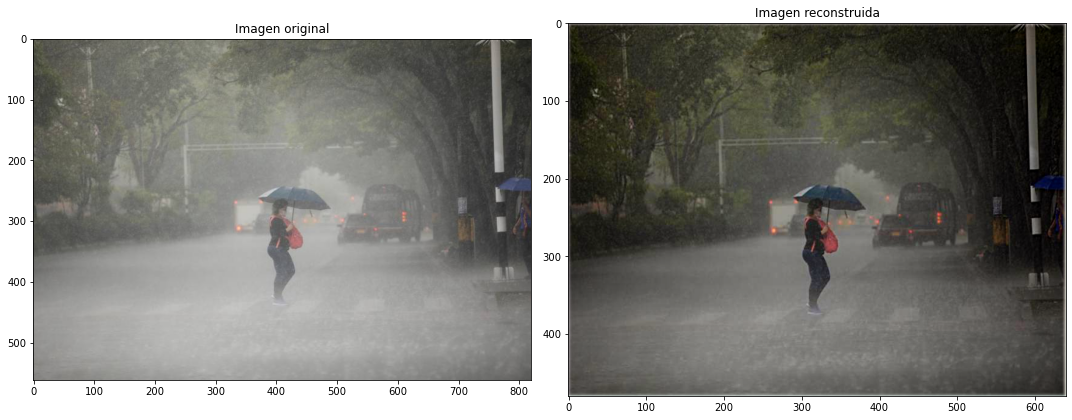

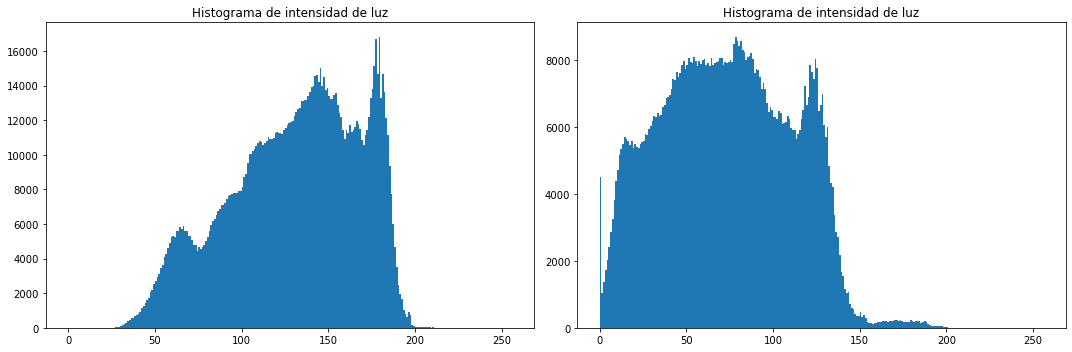

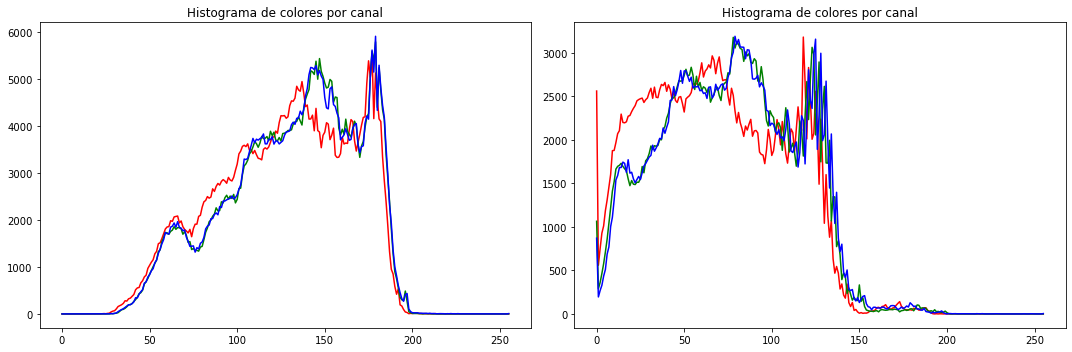

In [20]:
import matplotlib as mpl

def evaluarCNN():
    saver = tf.train.Saver();
    train_data, val_data = setup_data_paths(os.getcwd()+"/data/orig_images",
                                            os.getcwd()+"/data/hazy_images");

    test_input_folder = os.getcwd()+"/test_images";
    test_output_folder = os.getcwd()+"/dehazed_test_images";

    if not os.path.exists(test_output_folder):
      os.mkdir(test_output_folder);

    file_types = ['jpeg','jpg'];

    with tf.Session() as sess:
        saver.restore(sess,os.getcwd()+'/models/model_checkpoint_7.ckpt');
        test_image_paths = []
#         print(tf.profiler.profile(
#         sess.graph,
#         options=tf.profiler.ProfileOptionBuilder.float_operation()))
        for file_type in file_types:
            test_image_paths.extend(glob.glob(test_input_folder+"/*."+file_type));


        for path in test_image_paths:
            image_label = path.split(test_input_folder)[-1][1:];
            if nombre_im!=image_label[:-3]:
                continue
            image = Image.open(path)
            image = image.resize((640, 480))
            image = np.asarray(image) / 255.0
            image = image.reshape((1,) + image.shape)
            dehazed_image = sess.run(dehazed_X,feed_dict={X:image,Y:image});

            dehazed_image = np.asarray(dehazed_image[0] * 255,dtype=np.uint8)
            mpl.image.imsave(test_output_folder + "/" + 'dehazed_' + image_label, dehazed_image)
            #Para guardar la imagen en la carpeta principal

            mpl.image.imsave("CNNdehazed-"+nombre_im+"png", dehazed_image)
            HazeImg = cv2.imread(path)
            HazeCorrectedImg = cv2.imread("CNNdehazed-"+nombre_im+"png")
        return HazeCorrectedImg
            
CNNImg = evaluarCNN()
plot_results(HazeImg,CNNImg)

 <br><br>
 <h3 style="color:teal; display:inline"> MÉTODO YJN</h3><p style="color:teal; display:inline">(Yessica-Jorge-Nicolás)</p> 
 
Este es el método que proponemos basándonos en los resultados analizados en las 3 aproximaciones previas. El método que tomamos como base es el método de Roy-Chaudhuri y le agregamos una función de regularización para lograr un mejor contraste y suavida en la imagen final. Esta regularización la hacemos aplicando la transformada rápida discreta de Fourier y luego su inversa.

In [21]:
def TransmissionYJN(HazeImg, A):
    one_matrix = np.ones((HazeImg.shape[0],HazeImg.shape[1]))
    t_b = one_matrix-HazeImg[:, :, 0].astype(float)*(0.95/A[0])
    t_g = one_matrix-HazeImg[:, :, 1].astype(float)*(0.95/A[1])
    t_r = one_matrix-HazeImg[:, :, 2].astype(float)*(0.95/A[2])
    MaxVal = np.maximum(t_b, t_g, t_r)
    transmission = np.minimum(MaxVal, 1)
    return(transmission)

In [22]:
from skimage.io import imread, imshow
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage import color, exposure, transform
from skimage.exposure import equalize_hist

In [23]:
def regularizationYJN(image):
    HazeCorrectedImage = copy.deepcopy(image)
    transformed_channels = []
    for i in range(3):
        rgb_fft = np.fft.fft2((image[:, :, i]))
        rgb_fft[:225, 235:237] = 1
        rgb_fft[-225:,235:237] = 1
        HazeCorrectedImage[:,:,i]=abs(np.fft.ifft2(rgb_fft))
    return HazeCorrectedImage
    

In [24]:
def removeHazeYJN(HazeImg, delta):
    epsilon = 0.0001
    windowSize_erode=25
    A = Airlight(HazeImg, windowSize_erode)
    Transmission = TransmissionYJN(HazeImg,A)
    A_contrast = [(255-x)/255 for x in A]
    A_contrast = [1-np.max(A_contrast)+x for x in A_contrast]
    Transmission = pow(np.maximum(abs(Transmission), epsilon), delta)
    HazeCorrectedImage = copy.deepcopy(HazeImg)
    for ch in range(len(HazeImg.shape)):
        A_matrix = np.ones((HazeImg.shape[0],HazeImg.shape[1]))    
        A_matrix = A_matrix*A[ch]
        temp=np.divide((HazeImg[:, :, ch]-A_matrix),np.maximum(Transmission, epsilon))+A_matrix
        temp = np.maximum(np.minimum(temp, 255), 0)
        HazeCorrectedImage[:, :, ch] = temp
    RegularizedImage = regularizationYJN(HazeCorrectedImage)
    return(RegularizedImage) 

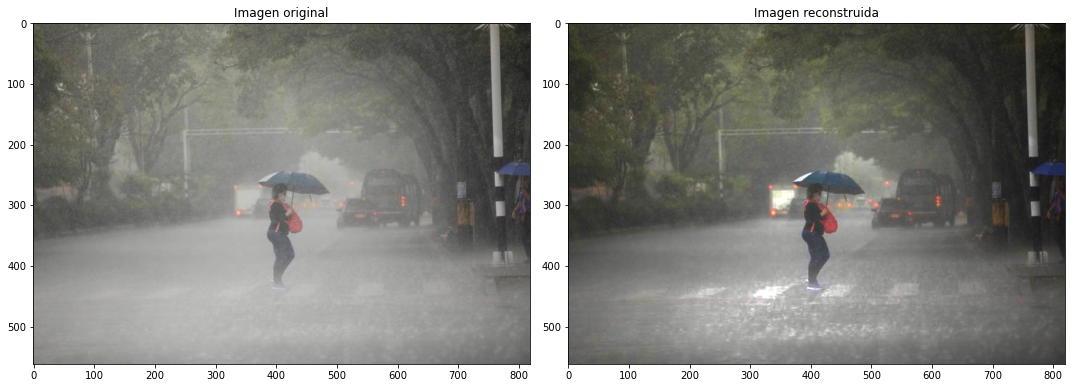

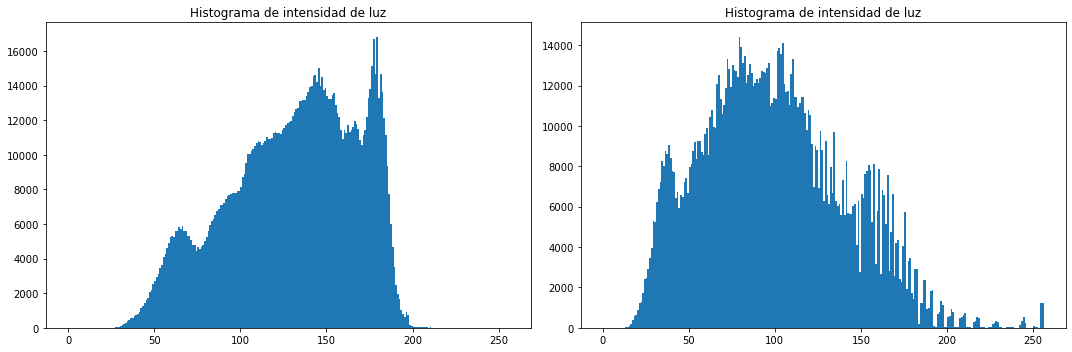

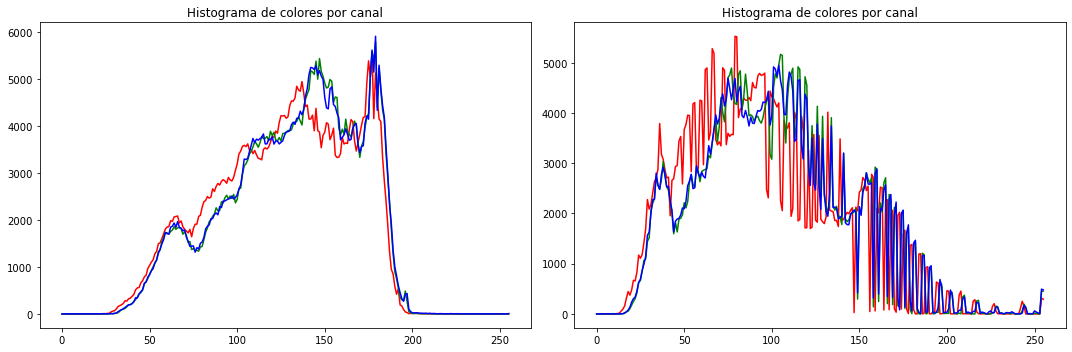

In [25]:
YJNImg = removeHazeYJN(HazeImg, 0.5)
plot_results(HazeImg,YJNImg);
# cv2.imwrite("YJNdehazed-"+nombre_im+"jpg",YJNDehaze)

<br><br>
<h2 style="color:darkblue">COMPARACIÓN DE RESULTADOS</h2>
<br>
<h3 style="color:teal">TIEMPO</h3> 

In [26]:
import time
from tabulate import tabulate
from IPython.utils import io

def execTime(verbose=False):
    # Optimización Convexa
    times=["Tiempo online (s)","N/A"]
    start_time = time.time()
    OCImg = removeHaze(HazeImg, 0.5, False);
    finish_time = time.time() - start_time
    times.append(finish_time)
#     times.append(24.05)

    # Método Roy-Chaudhuri
    start_time = time.time()
    RCImg = removeHazeRC(HazeImg, 0.5, True)
    finish_time = time.time() - start_time
    times.append(finish_time)

    # CNN
    start_time = time.time()
    with io.capture_output() as captured:
        CNNImg = evaluarCNN();    
    finish_time = time.time() - start_time
    times.append(finish_time)

    # Método YJN
    start_time = time.time()
    YJNImg = removeHazeYJN(HazeImg, 0.5);
    finish_time = time.time() - start_time
    times.append(finish_time)
    if verbose:        
        return times, OCImg, RCImg, CNNImg, YJNImg
    else:
        return times

<br>
<h3 style="color:teal">CONSTRASTE</h3> 

In [27]:
def contrastes():
    contrasts=["Contraste"]  
    
    # Foto Original
    min = int(np.min(HazeImg))
    max = int(np.max(HazeImg))
    contrast = (max-min)/(max+min)
    contrasts.append(contrast)
    
    
    # Optimización convexa
    min = int(np.min(OCImg))
    max = int(np.max(OCImg))
    contrast = (max-min)/(max+min)
    contrasts.append(contrast)
    
    # Método Roy-Chaudhuri
    min = int(np.min(RCImg))
    max = int(np.max(RCImg))
    contrast = (max-min)/(max+min)
    contrasts.append(contrast)
    
    # CNN
    min = int(np.min(CNNImg))
    max = int(np.max(CNNImg))
    contrast = (max-min)/(max+min)
    contrasts.append(contrast)
    
    # Método YJN
    min = int(np.min(YJNImg))
    max = int(np.max(YJNImg))
    contrast = (max-min)/(max+min)
    contrasts.append(contrast)
    
    return contrasts

<br>
<h3 style="color:teal">VARIACIÓN TOTAL</h3> 

In [28]:
def variaciones():
    variaciones=[[],[],[]]
    # Foto Original
    for ch, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            HazeImg[:, :, ch], bins=256, range=(0, 256)
        )
        variaciones[ch].append(np.var(histogram))   
    
    # Optimización convexa
    for ch, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            OCImg[:, :, ch], bins=256, range=(0, 256)
        )
        variaciones[ch].append(np.var(histogram))
    
    # Método Roy-Chaudhuri
    for ch, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            RCImg[:, :, ch], bins=256, range=(0, 256)
        )
        variaciones[ch].append(np.var(histogram))
        
    # CNN
    for ch, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            CNNImg[:, :, ch], bins=256, range=(0, 256)
        )
        variaciones[ch].append(np.var(histogram))
    
    # Método YJN
    for ch, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            YJNImg[:, :, ch], bins=256, range=(0, 256)
        )
        variaciones[ch].append(np.var(histogram))
    return variaciones

<br>
<h3 style="color:teal">CALIDAD DE LA IMAGEN</h3> 

In [29]:
def plot_results_ext():
    imagenes=[cv2.cvtColor(HazeImg, cv2.COLOR_BGR2RGB),cv2.cvtColor(OCImg, cv2.COLOR_BGR2RGB),
              cv2.cvtColor(RCImg, cv2.COLOR_BGR2RGB),cv2.cvtColor(CNNImg, cv2.COLOR_BGR2RGB),
              cv2.cvtColor(YJNImg, cv2.COLOR_BGR2RGB)]
    fig, axes = plt.subplots(nrows=1, ncols=5,figsize=(15,15))  
    axes.ravel()
#     plt.axis('off')    
    fig.tight_layout()
    axes[0].imshow(imagenes[0])
    axes[0].title.set_text("Original")     
    axes[1].imshow(imagenes[1])
    axes[1].title.set_text("Optimización convexa")
    axes[2].imshow(imagenes[2])
    axes[2].title.set_text("Método Roy-Chaudhuri")
    axes[3].imshow(imagenes[3])
    axes[3].title.set_text("CNN")
    axes[4].imshow(imagenes[2])
    axes[4].title.set_text("Método YJN")
    axes[0].axis('off')
    axes[1].axis('off')
    axes[2].axis('off')
    axes[3].axis('off')
    axes[4].axis('off') 
    fig.tight_layout()
    plt.show()
    fig1, axes1 = plt.subplots(nrows=1, ncols=5,figsize=(15,2.5))
    axes1[2].title.set_text("Histograma de intensidad de luz\n")
    axes1[0].hist(HazeImg.ravel(),256,[0,256])    
    axes1[1].hist(OCImg.ravel(),256,[0,256])    
    axes1[2].hist(RCImg.ravel(),256,[0,256])    
    axes1[3].hist(CNNImg.ravel(),256,[0,256]) 
    axes1[4].hist(YJNImg.ravel(),256,[0,256])
    axes1[0].get_yaxis().set_visible(False)
    axes1[1].get_yaxis().set_visible(False)
    axes1[2].get_yaxis().set_visible(False)
    axes1[3].get_yaxis().set_visible(False)
    axes1[4].get_yaxis().set_visible(False)
    fig1.tight_layout()

    fig2, axes2 = plt.subplots(nrows=1, ncols=5,figsize=(15,2.5))
    axes2[2].title.set_text("Histograma de colores por canal\n");
    axes2[0].get_yaxis().set_visible(False)
    axes2[1].get_yaxis().set_visible(False)
    axes2[2].get_yaxis().set_visible(False)
    axes2[3].get_yaxis().set_visible(False)
    axes2[4].get_yaxis().set_visible(False)

    for channel_id, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            HazeImg[:, :, channel_id], bins=256, range=(0, 256)
        )
        axes2[0].plot(bin_edges[0:-1], histogram, color=color)
    fig2.tight_layout()
    
    for channel_id, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            OCImg[:, :, channel_id], bins=256, range=(0, 256)
        )
        axes2[1].plot(bin_edges[0:-1], histogram, color=color)

    fig2.tight_layout()
    for channel_id, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            RCImg[:, :, channel_id], bins=256, range=(0, 256)
        )
        axes2[2].plot(bin_edges[0:-1], histogram, color=color)
    fig2.tight_layout()
    for channel_id, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            CNNImg[:, :, channel_id], bins=256, range=(0, 256)
        )
        axes2[3].plot(bin_edges[0:-1], histogram, color=color)
    fig2.tight_layout()
    
    for channel_id, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            YJNImg[:, :, channel_id], bins=256, range=(0, 256)
        )
        axes2[4].plot(bin_edges[0:-1], histogram, color=color)
    fig2.tight_layout()  

    

In [30]:
from tabulate import tabulate

def show_results(times):
    tabla=[["Métrica","Foto Original","Opt Convexa","Método RC", "Redes neuronales","Método YJN"]]    
    tabla.append(times)
    tabla.append(contrastes())
    variaciones_canales=variaciones()
    variaciones_canales[0].insert(0,"Variación canal rojo")
    variaciones_canales[1].insert(0,"Variación canal verde")
    variaciones_canales[2].insert(0,"Variación canal azul")
    tabla.append(variaciones_canales[0])
    tabla.append(variaciones_canales[1])
    tabla.append(variaciones_canales[2])
    print("")
    print(tabulate(tabla,headers='firstrow'))
    print("")
    print("")
    plot_results_ext()

C:\Users\Joluc\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


INFO:tensorflow:Restoring parameters from C:\Users\Joluc\Documents\Jorge\UNAL\2022-2\Numerico\image-dehazing/models/model_checkpoint_7.ckpt

Métrica                Foto Original         Opt Convexa    Método RC    Redes neuronales    Método YJN
---------------------  ------------------  -------------  -----------  ------------------  ------------
Tiempo online (s)      N/A                  39.727        0.102989            0.572804      0.242658
Contraste              0.8613138686131386    0.861314     0.924528            1             0.924528
Variación canal rojo   3057035.498474121     4.56258e+06  3.85795e+06         1.31113e+06   2.76476e+06
Variación canal verde  3354447.701599121     4.1522e+06   3.51689e+06         1.33432e+06   2.74478e+06
Variación canal azul   3307310.115661621     3.99312e+06  3.24977e+06         1.31942e+06   2.65131e+06




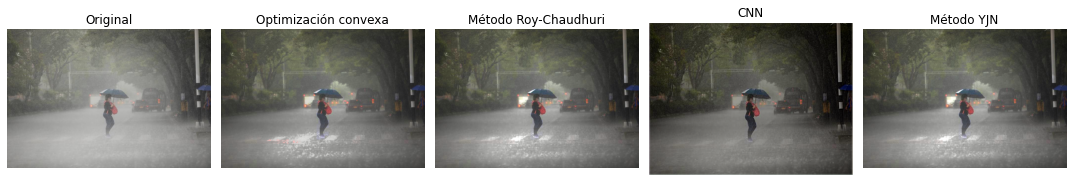

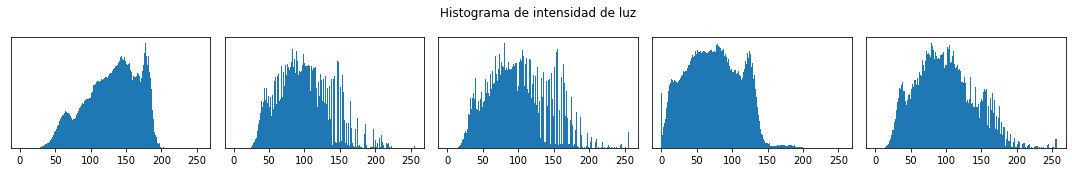

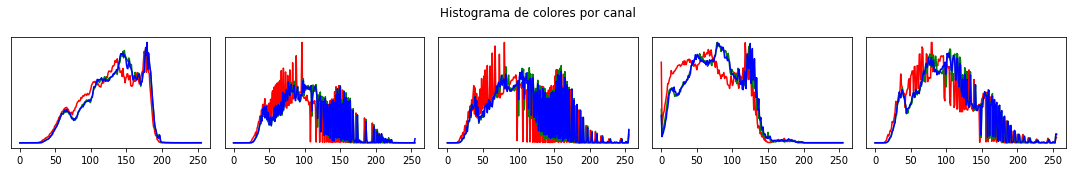

In [31]:
HazeImg = cv2.imread("test1.jpg")
nombre_im ="test1."
times, OCImg, RCImg, CNNImg, YJNImg = execTime(True)
show_results(times)

C:\Users\Joluc\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


INFO:tensorflow:Restoring parameters from C:\Users\Joluc\Documents\Jorge\UNAL\2022-2\Numerico\image-dehazing/models/model_checkpoint_7.ckpt

Métrica                Foto Original         Opt Convexa     Método RC    Redes neuronales      Método YJN
---------------------  ---------------  ----------------  ------------  ------------------  --------------
Tiempo online (s)      N/A                   9.20651           0.02999         0.624972          0.0649981
Contraste              1.0                   1                 1               1                 1
Variación canal rojo   395737.65625     768222            710563               8.37167e+06  590963
Variación canal verde  1163929.5859375       1.05154e+06  975811               1.84602e+06  860181
Variación canal azul   626612.0546875   735956            518859          839468            504484




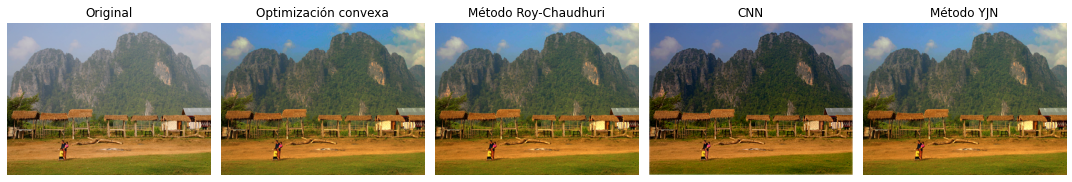

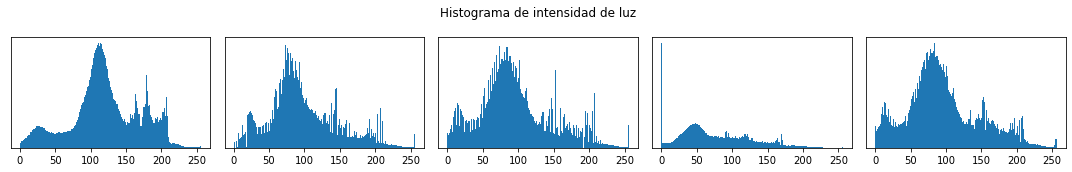

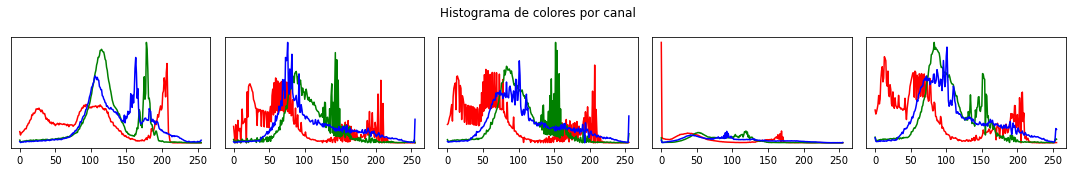

In [32]:
HazeImg = cv2.imread("test2.jpg")
nombre_im ="test2."
times, OCImg, RCImg, CNNImg, YJNImg = execTime(True)
show_results(times)

C:\Users\Joluc\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


INFO:tensorflow:Restoring parameters from C:\Users\Joluc\Documents\Jorge\UNAL\2022-2\Numerico\image-dehazing/models/model_checkpoint_7.ckpt

Métrica                Foto Original           Opt Convexa         Método RC    Redes neuronales        Método YJN
---------------------  -----------------  ----------------  ----------------  ------------------  ----------------
Tiempo online (s)      N/A                    15.8778            0.0400031           0.776634          0.106
Contraste              1.0                     1                 1                   1                 1
Variación canal rojo   609597.9196777344  701788            747700                   6.44336e+06  456990
Variación canal verde  308509.3884277344  901904            769322              482761            546458
Variación canal azul   313113.4353027344       1.50971e+06       1.14911e+06         1.16139e+06       1.04789e+06




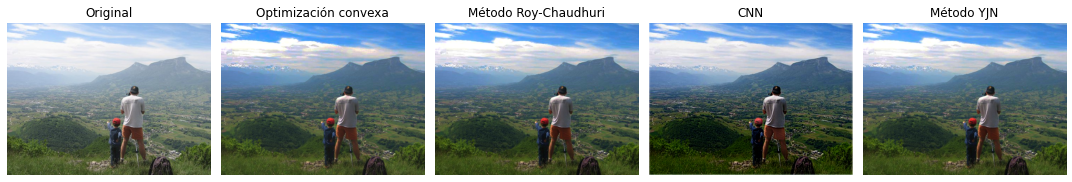

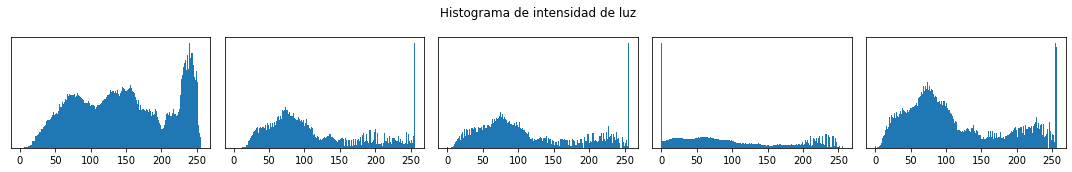

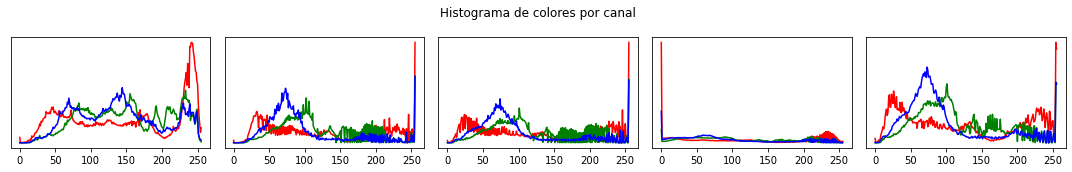

In [33]:
HazeImg = cv2.imread("test3.jpg")
nombre_im ="test3."
times, OCImg, RCImg, CNNImg, YJNImg = execTime(True)
show_results(times)